# Metrics and Error Analysis

In the previous chapters, we trained and exported a computer vision model on the 5-flowers dataset. We saw that our model could achieve good overall accuracy on the validation set. But **accuracy alone doesn’t tell the full story**.  

In real-world machine learning systems, especially those deployed in production, we need to ask questions like:

- Which classes are being misclassified most often?
- Are some subsets of the data harder for the model than others?
- How confident can we be in individual predictions?
- How can we systematically detect issues before deployment?

This notebook introduces **detailed evaluation techniques** that go beyond simple accuracy metrics:

1. Compute **per-class metrics**: precision, recall, F1 score.
2. Visualize performance with **confusion matrices**.
3. Inspect **misclassified examples** to gain intuition about model weaknesses.
4. Lay the foundation for **monitoring and fairness considerations** in later notebooks.

By the end of this notebook, you will have a clearer understanding of **where your model succeeds and where it fails**, which is a critical skill for building production-ready computer vision systems.


In [20]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import os

# Load Dataset

# -----------------------------
# Important: IMG_SIZE must match the model's expected input.
# - If you are loading a saved model from a previous session, keep IMG_SIZE = 128 (since that's what it used)
# - If no saved model exists and a new model is trained, you can use IMG_SIZE = 224
# Changing this incorrectly will cause shape mismatch errors!
# -----------------------------
IMG_SIZE = 128
BATCH_SIZE = 32

(ds_train, ds_val), ds_info = tfds.load(
    "tf_flowers",
    split=["train[:80%]", "train[80%:]"],
    as_supervised=True,
    with_info=True
)

NUM_CLASSES = ds_info.features["label"].num_classes
CLASS_NAMES = ds_info.features["label"].names

def preprocess(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = image / 255.0
    return image, label

ds_val = ds_val.map(preprocess).batch(BATCH_SIZE)


In [21]:
# Load Model (or create fallback lightweight model)

MODEL_PATH = "saved_model/flowers_model" #Update path to your saved model (or leave as-is to generate a new one)
# Example: MODEL_PATH = "..\\07_training\\model_registry\\v_20260215_185521\\" 
# --> ".." traverses one parent directory
# --> The double backslashes are needed on Windows (the first backslash protects the second from Python interpretation)

if os.path.exists(MODEL_PATH):
    model = tf.keras.models.load_model(MODEL_PATH)
    print("Loaded saved model.")
    if model.input_shape[1] != IMG_SIZE:
        print(f"⚠️ Warning: Model expects input size {model.input_shape[1]}x{model.input_shape[2]}, "
              f"but IMG_SIZE is set to {IMG_SIZE}. Resize in preprocessing accordingly!")
else:
    print("Saved model not found. Training quick lightweight model...")
    base = tf.keras.applications.MobileNetV2(
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
        include_top=False,
        weights="imagenet"
    )
    base.trainable = False

    model = tf.keras.Sequential([
        base,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(NUM_CLASSES, activation="softmax")
    ])

    model.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

    ds_train = ds_train.map(preprocess).batch(BATCH_SIZE)
    model.fit(ds_train, epochs=1)


Saved model not found. Training quick lightweight model...
92/92 [==============================] - 10s 77ms/step - loss: 0.7571 - accuracy: 0.7197


In [22]:
# Evaluate

y_true = []
y_pred = []

for images, labels in ds_val:
    preds = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))


In [23]:
# Classification Report

print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))


              precision    recall  f1-score   support

   dandelion       0.84      0.89      0.86       159
       daisy       0.82      0.87      0.84       120
      tulips       0.87      0.75      0.81       186
  sunflowers       0.84      0.83      0.83       138
       roses       0.76      0.84      0.80       131

    accuracy                           0.83       734
   macro avg       0.83      0.83      0.83       734
weighted avg       0.83      0.83      0.83       734



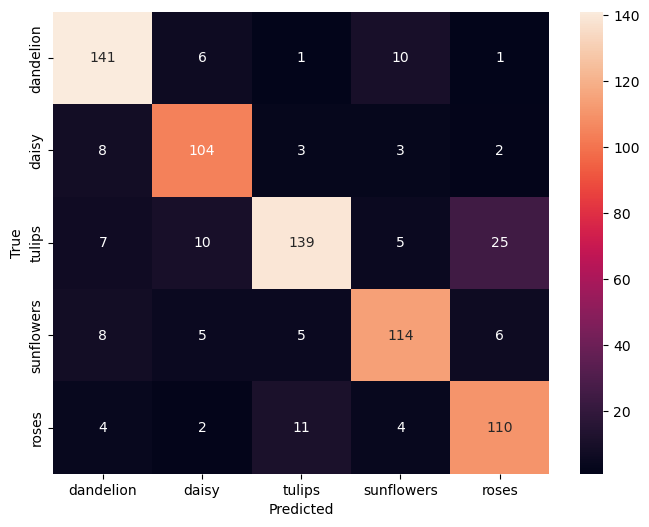

In [24]:
# Confusion Matrix

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=CLASS_NAMES,
            yticklabels=CLASS_NAMES)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


1/1 [==============================] - 0s 97ms/step


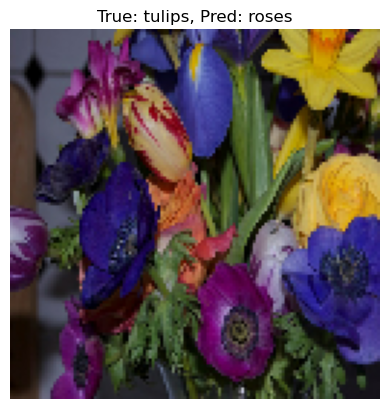

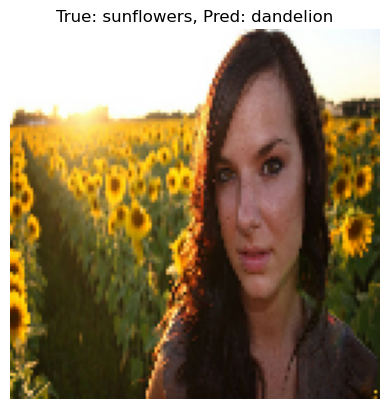

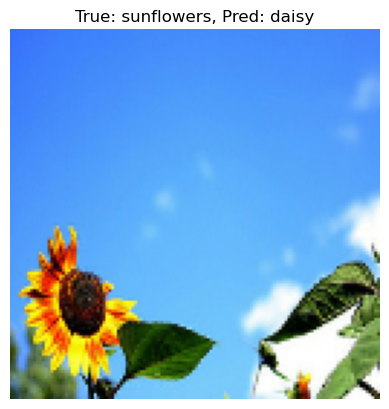

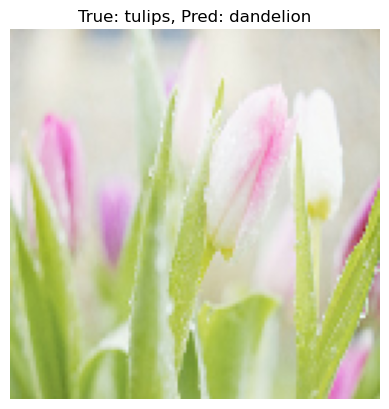

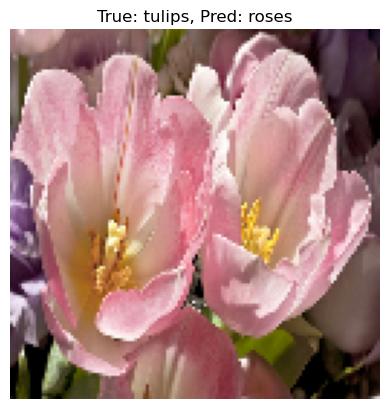

In [25]:
# Misclassified Examples

misclassified_count = 0
max_to_show = 5

# Iterate over the validation dataset (batched)
for images, labels in ds_val:
    preds = model.predict(images)
    preds = np.argmax(preds, axis=1)

    # Convert tensors to numpy
    images_np = images.numpy()
    labels_np = labels.numpy()

    for i in range(len(labels_np)):
        if preds[i] != labels_np[i]:
            plt.imshow(images_np[i])
            plt.title(f"True: {CLASS_NAMES[labels_np[i]]}, Pred: {CLASS_NAMES[preds[i]]}")
            plt.axis("off")
            plt.show()

            misclassified_count += 1
            if misclassified_count >= max_to_show:
                break
    if misclassified_count >= max_to_show:
        break
